In [3]:
import torch
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def plot_forward(net,conductivity=None,heat_source=None):

    x=np.arange(0,2,0.02)
    t=np.arange(0,1,0.02)
    ms_x, ms_t = np.meshgrid(x, t)
    x_all = np.ravel(ms_x).reshape(-1,1)
    t_all = np.ravel(ms_t).reshape(-1,1)
    pt_x = Variable(torch.from_numpy(x_all).float(), requires_grad=False).to(device)
    pt_t = Variable(torch.from_numpy(t_all).float(), requires_grad=False).to(device)

    if heat_source is not None:

      pt_u = heat_source(pt_x,pt_t)
      u=pt_u.data.cpu().numpy()
      ms_u = u.reshape(ms_x.shape)

      fig = plt.figure()
      ax = fig.add_subplot(projection = '3d')

      surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
      fig.colorbar(surf, shrink=0.4, aspect=5)
      plt.xlabel('x')
      plt.ylabel('t')
      plt.title('heat source q(x,t)')
      plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')

    pt_u = net(pt_x,pt_t)
    u=pt_u.data.cpu().numpy()
    ms_u = u.reshape(ms_x.shape)

    surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.4, aspect=5)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('temperature u(x,t)')
    plt.show()



    if conductivity is not None:
      u = conductivity( Variable(torch.from_numpy(x).float()) )

      plt.plot(x,u,'+')
      plt.xlabel('x')
      plt.ylabel('k')
      plt.title('conductivity k(x)')
      plt.show()

**Definition du probleme de transfert de chaleur**

In [19]:
class forward_problem:
  def __init__(self,net=None):
    #la variable net sera la fonction de regression qui approximera le champ de chaleur
    if net is not None:
      self.net = net

  def heat_source(self,x,t):
    #la valeur du terme source de chaleur q(x,t), qui peut etre dans un premier temps zero partout
    q = 0

    return q

  def advection(self,x,t,u, beta, uref):
    #la valeur du terme d'advection
    q = beta*(u-uref)

    return q

  def conductivity(self,x):
    k = 1

    return k

  def heat_capacity(self,x):
    #la chaleur specifique qui peut varier dans le milieu; par defaut, constante et egale à 1
    c = 1

    return c

  def ic(self,x):
    #conditions initiales
    ic = 0

    return ic

  def bc(self,x,t):
    #conditions aux limites
    Tu = 0.1
    B=1
    bc = torch.where(x==0,B*(1-torch.exp(-t/Tu)),0.0)

    return bc

  def f(self,x,t):
    #l'estimation :
    u = self.net(x,t)

    #u_x recupere les gradients de u par rapport à x
    #torch.autograd.grad renvoie un tuple, le grad est la premiere valeur
    u_x = torch.autograd.grad(
      u, x,
      grad_outputs=torch.ones_like(u),
      retain_graph=True,
      create_graph=True
    )[0]

    flux = -1.0*self.conductivity(x) * u_x

    #faire pareil avec flux_x. Si vous le laissez à zero, pas de flux
    flux_x = torch.autograd.grad(
      flux, x,
      grad_outputs=torch.ones_like(flux),
      retain_graph=True,
      create_graph=True
    )[0]

    #faire pareil avec u_t
    u_t = torch.autograd.grad(
      u, t,
      grad_outputs=torch.ones_like(u),
      retain_graph=True,
      create_graph=True
    )[0]


    #ecrire le  residuel pour (x,t) en fonction de l'equation diff de la chaleur
    c = 1
    beta = 0
    residual = c*u_t + flux_x + self.advection(x,0,u,0,0) - self.heat_source(x,0)

    return residual

  #residuel conditions aux bords
  def f_bc(self,x,t):
    u = self.net(x,t)
    residual = u - self.bc(x,t)

    return residual

  #residuel conditions initiales
  def f_ic(self,x,t):
    u = self.net(x,t)
    residual = u - self.ic(x)

    return residual

  def solve(self,N_iter=1000):
    solve(self,N_iter)

  def plot_forward(self):
    plot_forward(self.net)


**La definition du reseau de neurones**

In [6]:
# un reseau standard feed forward
# le choix des parametres reste toujours un probleme ouvert
class FCN(torch.nn.Module):
    def __init__(self):
      super(FCN, self).__init__()
      self.hidden_layer1 = torch.nn.Linear(2,100)
      self.hidden_layer2 = torch.nn.Linear(100,10)
      self.output_layer = torch.nn.Linear(10,1)

    def forward(self, x,t):
      inputs = torch.cat([x,t],axis=1) # on concatene pour avoir une seule variable
      layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
      layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
      output = self.output_layer(layer2_out) ## pour une regression, pas d'activation apres la derniere couche
      return output

In [13]:
def solve(problem,N_iter=1000):

    net = problem.net

    mse_cost_function = torch.nn.MSELoss() # Mean squared error
    optimizer = torch.optim.Adam(net.parameters(),lr=1.0e-2, weight_decay=1.0e-100)

    # echantillonage aleatoire dans le domaine de x
    pt_x_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)

    # echantillonage aleatoire dans le domaine de t
    pt_t_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 1.0), requires_grad=True).to(device)


    # echantillonage aleatoire dans le domaine de x pour les conditions initiales
    pt_x_collocation_ic = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)


    # t pour ic?
    pt_t_collocation_ic = Variable(torch.Tensor(100,1).uniform_(0.0, 0.0), requires_grad=True).to(device)


    # generer des x aleatoires pour les conditions aux bords
    pt_x_collocation_bc = Variable(torch.randint(0,2,(100,1),dtype=torch.float)*2,requires_grad=True).to(device)
    # attention verifier les valeurs, randint a besoin de (valeur max + 1) pour generer valeur max


    # echantillonage aleatoire dans le domaine de t
    pt_t_collocation_bc = Variable(torch.randint(0,101,(100,1),dtype=torch.float)*0.01,requires_grad=True).to(device)


    #attention si l'echantillonage est aleatoire, il faut faire egalement ces tirages partout dans la boucle d'etntrainement

    randomise_colloc = 1
    for epoch in range(N_iter):
        optimizer.zero_grad() # to make the gradients zero

        # Loss based on PDE
        if  randomise_colloc==1:
            pt_x_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)

            pt_t_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 1.0), requires_grad=True).to(device)

        f_out = problem.f(pt_x_collocation, pt_t_collocation) # output of f(x,t)
        pt_all_zeros  = Variable(torch.zeros_like(f_out), requires_grad=False).to(device)
        mse_f = mse_cost_function(f_out, pt_all_zeros)

        # Loss ic
        if  randomise_colloc==1:
            pt_x_collocation_ic = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)

            pt_t_collocation_ic = Variable(torch.Tensor(100,1).uniform_(0.0, 0.0), requires_grad=True).to(device)

        f_out_ic  = problem.f_ic(pt_x_collocation_ic , pt_t_collocation_ic)
        pt_all_zeros  = Variable(torch.zeros_like(f_out_ic), requires_grad=False).to(device)
        mse_ic = mse_cost_function(f_out_ic , pt_all_zeros )

        # Loss bc
        if  randomise_colloc==1:
            pt_x_collocation_bc = Variable(torch.randint(0,2,(100,1),dtype=torch.float)*2,requires_grad=True).to(device)

            pt_t_collocation_bc = Variable(torch.randint(0,101,(100,1),dtype=torch.float)*0.01,requires_grad=True).to(device)

        f_out_bc = problem.f_bc(pt_x_collocation_bc , pt_t_collocation_bc) # output of f(x,t)
        pt_all_zeros  = Variable(torch.zeros_like(f_out_bc), requires_grad=False).to(device)
        mse_bc = mse_cost_function(f_out_bc , pt_all_zeros )

        # loss globale!
        loss = mse_f + mse_ic + mse_bc

        loss.backward() # calcul gradients en backprop
        optimizer.step() # equivalent à : theta_new = theta_old - alpha * derivee de J w.r.t theta

        # print loss
        if epoch<=10 or epoch==25 or epoch==50 or epoch%100==0:
          with torch.autograd.no_grad():
            print(epoch,"Traning Loss:",loss.data)


        if epoch<=10 or epoch==25 or epoch==50 or epoch==100 or epoch==250 or epoch%500==0:

          problem.plot_forward()

**La procedure d'entrainement**

**Instantiation**

<IPython.core.display.Javascript object>

0 Traning Loss: tensor(0.3473)


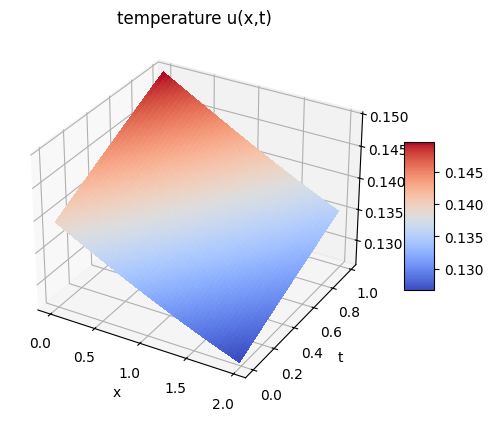

1 Traning Loss: tensor(0.2884)


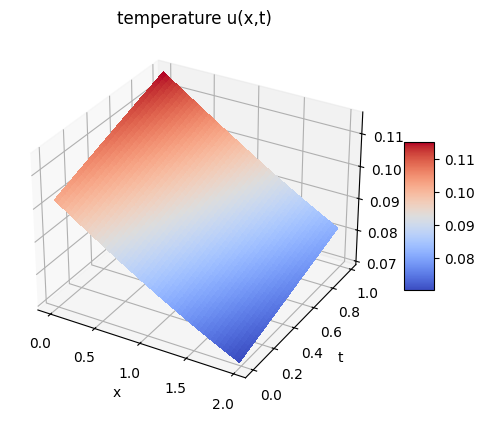

2 Traning Loss: tensor(0.3894)


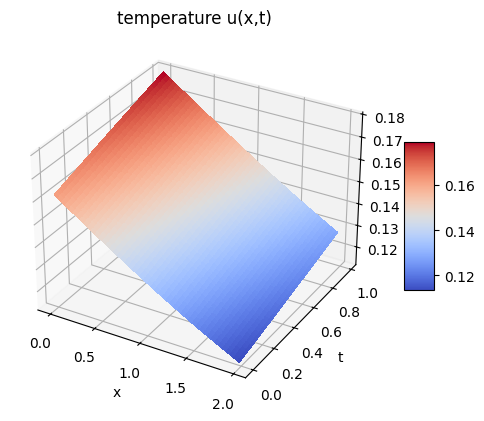

3 Traning Loss: tensor(0.3043)


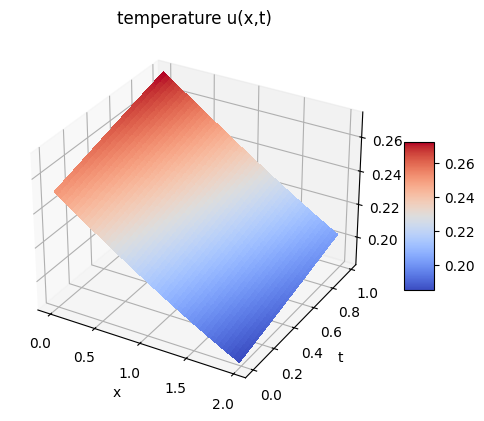

4 Traning Loss: tensor(0.2891)


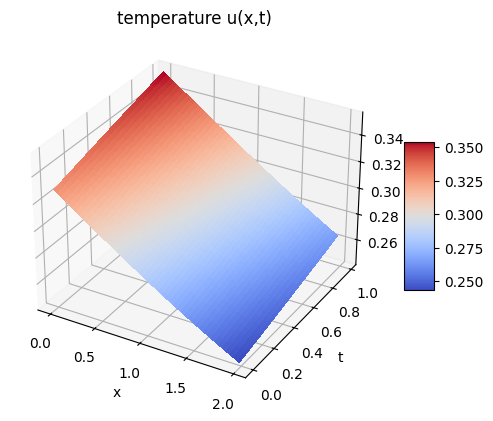

5 Traning Loss: tensor(0.3160)


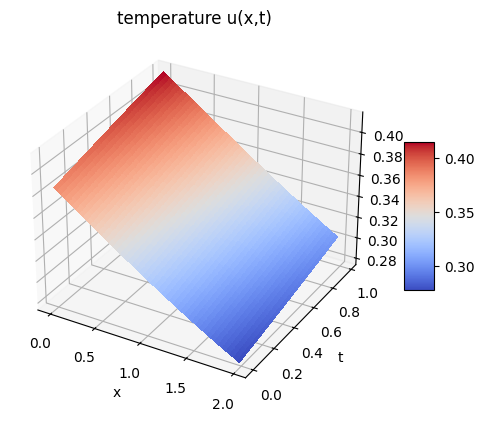

6 Traning Loss: tensor(0.3011)


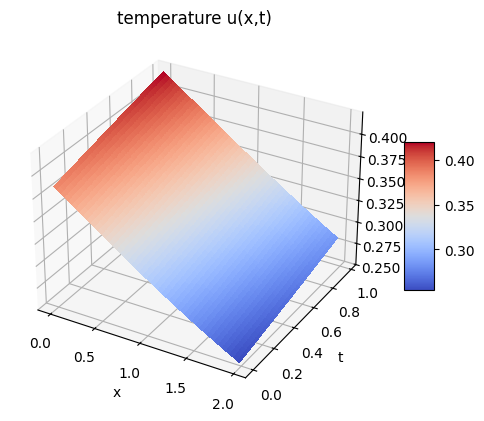

7 Traning Loss: tensor(0.2744)


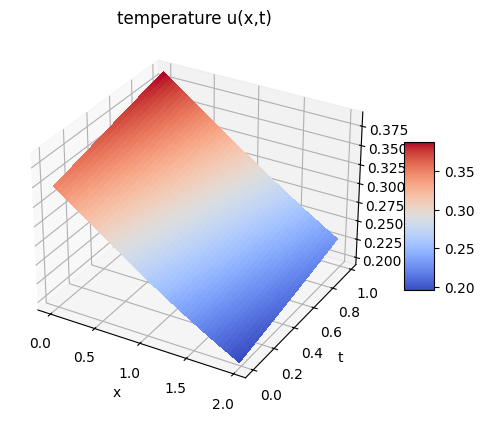

8 Traning Loss: tensor(0.2613)


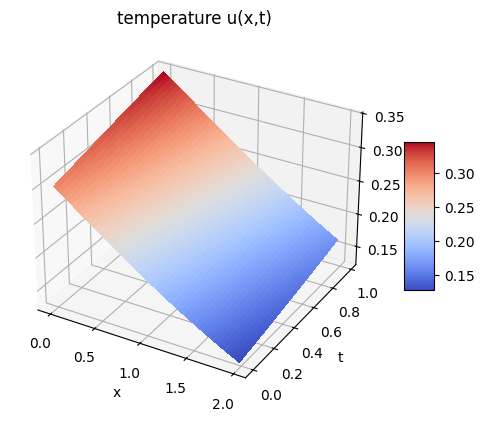

9 Traning Loss: tensor(0.2211)


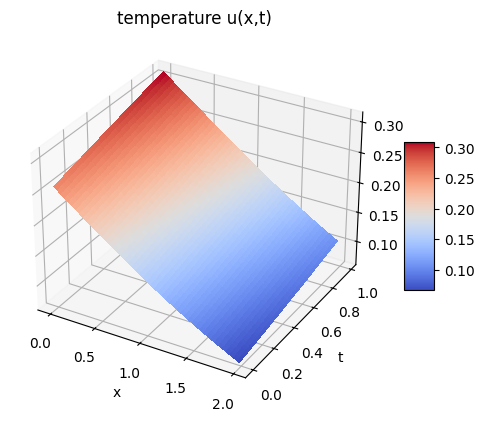

10 Traning Loss: tensor(0.2010)


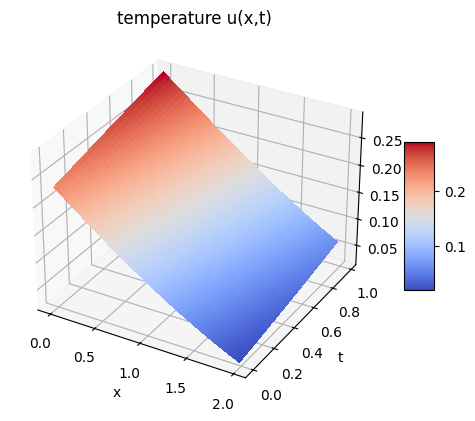

25 Traning Loss: tensor(0.1230)


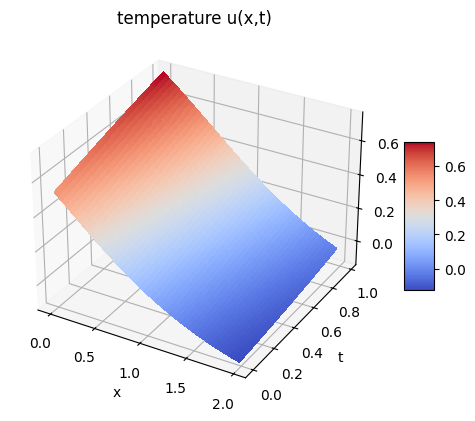

50 Traning Loss: tensor(0.0782)


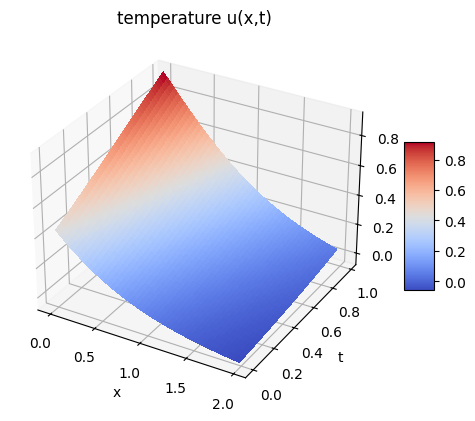

100 Traning Loss: tensor(0.0575)


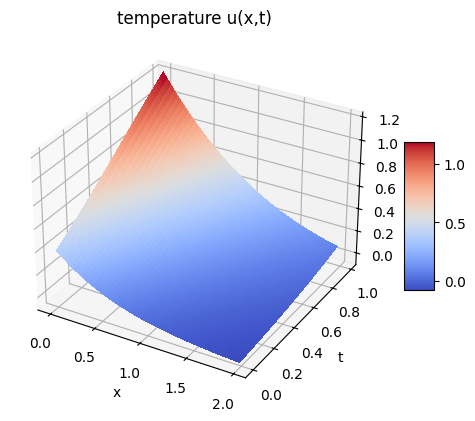

200 Traning Loss: tensor(0.0345)


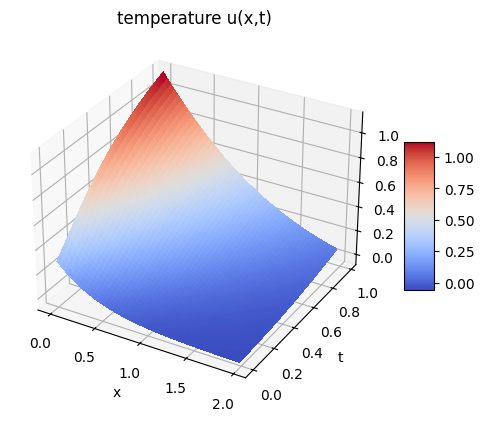

300 Traning Loss: tensor(0.0186)
400 Traning Loss: tensor(0.0116)
500 Traning Loss: tensor(0.0133)


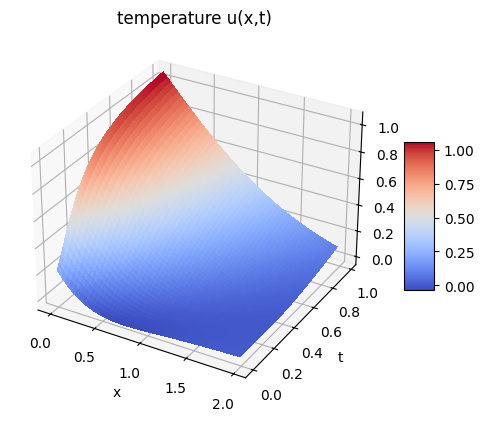

600 Traning Loss: tensor(0.0077)
700 Traning Loss: tensor(0.0071)
800 Traning Loss: tensor(0.0053)
900 Traning Loss: tensor(0.0054)
1000 Traning Loss: tensor(0.0042)


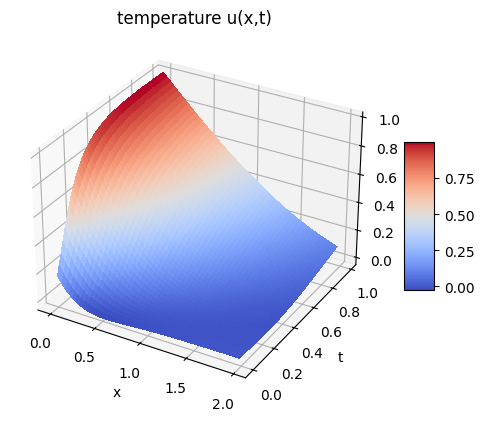

1100 Traning Loss: tensor(0.0079)
1200 Traning Loss: tensor(0.0046)
1300 Traning Loss: tensor(0.0033)
1400 Traning Loss: tensor(0.0051)
1500 Traning Loss: tensor(0.0034)


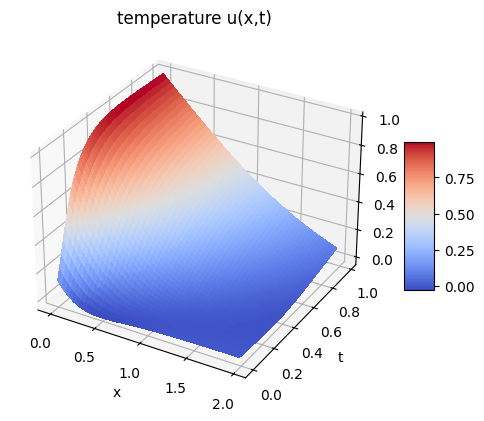

1600 Traning Loss: tensor(0.0049)
1700 Traning Loss: tensor(0.0032)
1800 Traning Loss: tensor(0.0032)
1900 Traning Loss: tensor(0.0025)
2000 Traning Loss: tensor(0.0029)


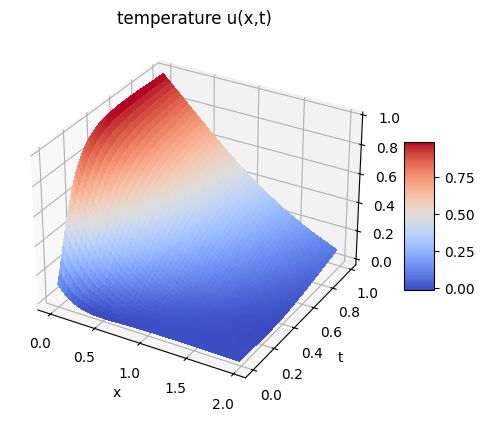

2100 Traning Loss: tensor(0.0018)
2200 Traning Loss: tensor(0.0034)
2300 Traning Loss: tensor(0.0017)
2400 Traning Loss: tensor(0.0029)
2500 Traning Loss: tensor(0.0025)


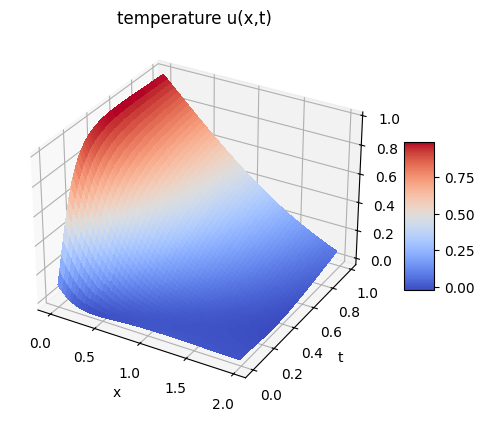

2600 Traning Loss: tensor(0.0024)
2700 Traning Loss: tensor(0.0019)
2800 Traning Loss: tensor(0.0018)
2900 Traning Loss: tensor(0.0054)
3000 Traning Loss: tensor(0.0012)


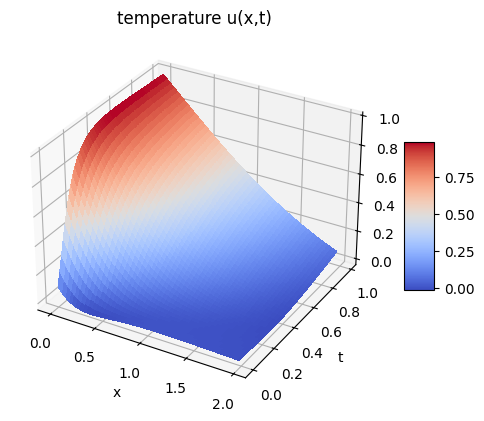

3100 Traning Loss: tensor(0.0019)
3200 Traning Loss: tensor(0.0014)
3300 Traning Loss: tensor(0.0014)
3400 Traning Loss: tensor(0.0023)
3500 Traning Loss: tensor(0.0013)


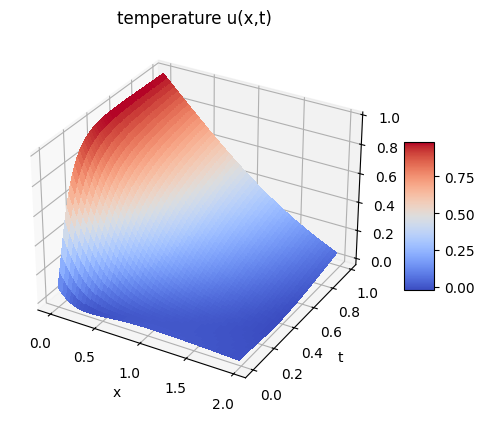

3600 Traning Loss: tensor(0.0047)
3700 Traning Loss: tensor(0.0011)
3800 Traning Loss: tensor(0.0010)
3900 Traning Loss: tensor(0.0015)
4000 Traning Loss: tensor(0.0012)


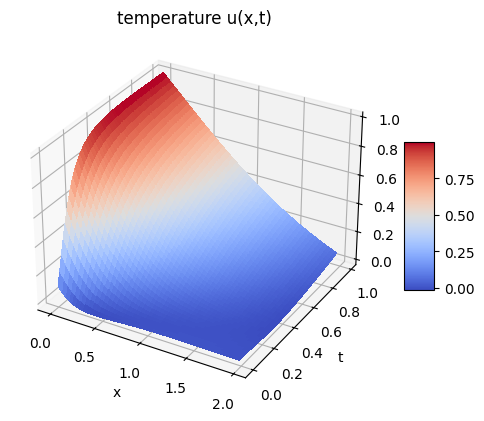

4100 Traning Loss: tensor(0.0009)
4200 Traning Loss: tensor(0.0012)
4300 Traning Loss: tensor(0.0014)
4400 Traning Loss: tensor(0.0019)
4500 Traning Loss: tensor(0.0008)


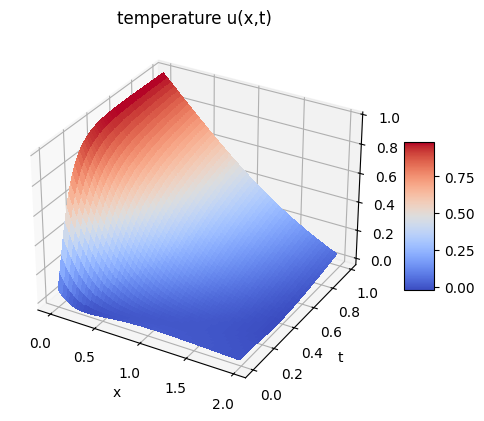

4600 Traning Loss: tensor(0.0025)
4700 Traning Loss: tensor(0.0008)
4800 Traning Loss: tensor(0.0009)
4900 Traning Loss: tensor(0.0020)


In [20]:
net = FCN().to(device)
heat_equation = forward_problem(net)

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

heat_equation.solve(N_iter=5000)